In [49]:
import numpy as np

from transformers import GPT2Tokenizer, GPT2LMHeadModel

## Naive Sampling

In [50]:
def get_naive_sample(model, tokenizer, input_str, avoid_terms, n, seed, max_num_tokens=5, debug=False):
    from sampling import importance_sampling, naive_sampling
    from utils import set_seed, create_history, create_model_kwargs
    
    # Parse input and set seeds for reproducibility
    set_seed(seed)
    bos_token_id = tokenizer.bos_token_id or model.config.decoder_start_token_id
    input_ids = tokenizer(input_str, return_tensors="pt", add_special_tokens=False).input_ids

    # some models have different representations for the same term depending on
    # whether they are preceeded with a space or not (we account for that by
    # producing a double-length list of terms to avoid, so that we can)
    # this list is actually reduced to the unique terms within the sampling methods.
    avoid_terms_ids = tokenizer(avoid_terms, add_special_tokens=False).input_ids

    # History (or past observations) and model_kwargs will be the same for all queries
    history = create_history(n, input_ids, bos_token_id)

    # Call Naive Sampling
    probabilities, samples = naive_sampling(
        avoid_term_ids=avoid_terms_ids,
        **create_model_kwargs(history, model, tokenizer),
        max_num_tokens=max_num_tokens,
        model=model,
        tokenizer=tokenizer,
    )
   

    if debug:
        mean, std = probabilities.mean().item(), probabilities.std().item()
        print("Freq:", mean, "Std:", std)
        print("Produced samples")
        print("\n".join(tokenizer.batch_decode(samples)[::5]))

    return probabilities, samples



## Importance sampling

In [51]:
from utils import set_seed
from tqdm import tqdm
set_seed(42)

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns

In [133]:
def get_imp_sample(model, tokenizer, input_str, avoid_terms, n, seed, max_num_tokens=5, debug=False):
    from sampling import importance_sampling, naive_sampling
    from utils import set_seed, create_history, create_model_kwargs
    
    # Parse input and set seeds for reproducibility
    set_seed(seed)
    bos_token_id = tokenizer.bos_token_id or model.config.decoder_start_token_id
    input_ids = tokenizer(input_str, return_tensors="pt", add_special_tokens=False).input_ids

    # some models have different representations for the same term depending on
    # whether they are preceeded with a space or not (we account for that by
    # producing a double-length list of terms to avoid, so that we can)
    # this list is actually reduced to the unique terms within the sampling methods.
    avoid_terms_ids = tokenizer(avoid_terms, add_special_tokens=False).input_ids

    # History (or past observations) and model_kwargs will be the same for all queries
    history = create_history(n, input_ids, bos_token_id)

    probabilities, samples, _ = importance_sampling(
        avoid_term_ids=avoid_terms_ids,
        **create_model_kwargs(history, model, tokenizer),
        max_num_tokens=max_num_tokens,
        model=model,
        tokenizer=tokenizer,
    )
    
    return probabilities, samples


def compute_mean_std(array, stepsize=5):
    means = []
    stds = []
    ids = []
    
    for i in range(5, len(array), stepsize):
        mean = array[:i].mean().item()
        means.append(mean)
        
        std = array[:i].std().item()
        stds.append((mean-std, mean+std))
        ids.append(i)
    else:
        mean = array.mean().item()
        means.append(mean)
        std = array.std().item()
        stds.append((mean-std, mean+std))
        ids.append(len(array))
        
    return means, stds, ids

In [134]:
SEEDS = np.unique(np.random.randint(0, 10**6, 70))
print("using", len(SEEDS), "seeds")

# User definitions
model_name = "gpt2"
num_samples = 100

# ==========================================================
# Load models
tokenizer = GPT2Tokenizer.from_pretrained(model_name, model_max_length=512)
model = GPT2LMHeadModel.from_pretrained(model_name, pad_token_id=tokenizer.eos_token_id)

print("Total #sequences:", 10*num_samples)

using 70 seeds
Total #sequences: 1000


Text(0.5, 1.0, 'I love  the this that you u')

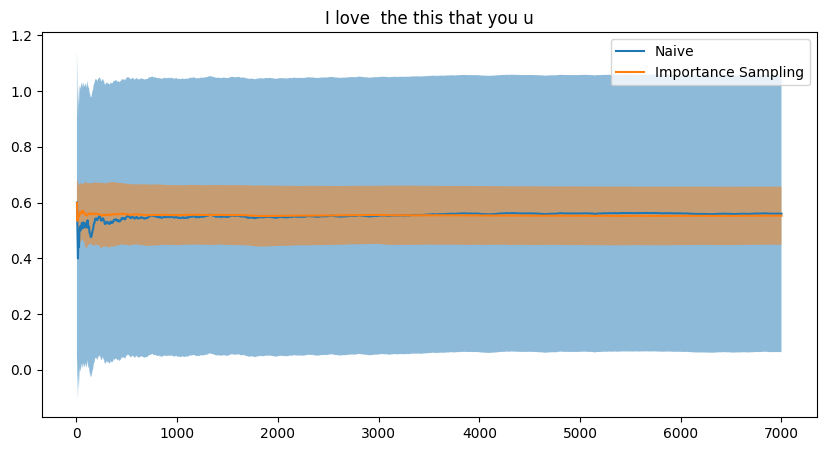

In [141]:
input_str, avoid_terms = "I love", " the this that you u"
naive_estimates, imp_estimates = [], []

for seed in SEEDS:
    naive_out = get_naive_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)
    naive_estimates.append(naive_out)
    
    imp_samp_out = get_imp_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)
    imp_estimates.append(imp_samp_out)
    
    
naive_probs, naive_samples = zip(*naive_estimates)
naive_probs = torch.cat(naive_probs)
naive_samples = torch.cat(naive_samples)

imp_probs, imp_samples = zip(*imp_estimates)
imp_probs = torch.cat(imp_probs)
imp_samples = torch.cat(imp_samples)

naive_mean, naive_std, naive_ids = compute_mean_std(naive_probs)
imp_mean, imp_std, imp_ids = compute_mean_std(imp_probs)

plt.figure(figsize=(10, 5))
ax = sns.lineplot(x=naive_ids, y=naive_mean, label="Naive")
ax.fill_between(naive_ids, *zip(*naive_std), alpha=0.5)

ax=sns.lineplot(x=imp_ids, y=imp_mean, label="Importance Sampling")
ax.fill_between(imp_ids, *zip(*imp_std), alpha=0.5)

plt.title(input_str + " " + avoid_terms)

Text(0.5, 1.0, 'In my opinion  the you she .')

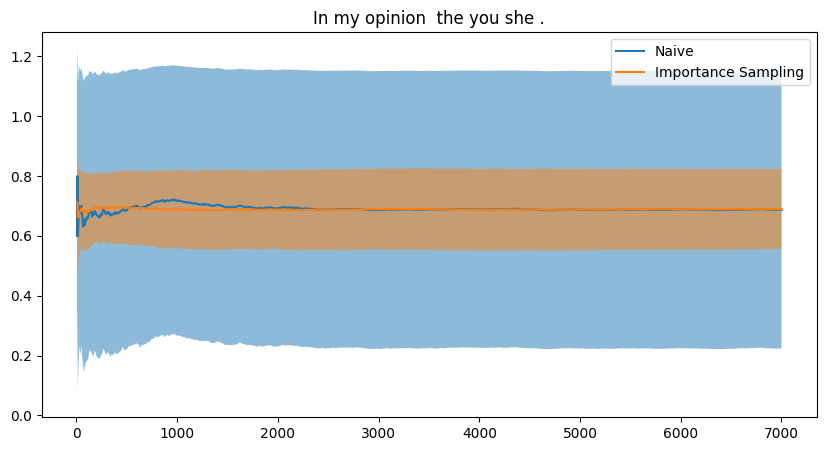

In [142]:
input_str, avoid_terms = "In my opinion", " the you she ."
naive_estimates, imp_estimates = [], []

for seed in SEEDS:
    naive_out = get_naive_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)
    naive_estimates.append(naive_out)
    
    imp_samp_out = get_imp_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)
    imp_estimates.append(imp_samp_out)
    
    
naive_probs, naive_samples = zip(*naive_estimates)
naive_probs = torch.cat(naive_probs)
naive_samples = torch.cat(naive_samples)

imp_probs, imp_samples = zip(*imp_estimates)
imp_probs = torch.cat(imp_probs)
imp_samples = torch.cat(imp_samples)

naive_mean, naive_std, naive_ids = compute_mean_std(naive_probs)
imp_mean, imp_std, imp_ids = compute_mean_std(imp_probs)

plt.figure(figsize=(10, 5))
ax = sns.lineplot(x=naive_ids, y=naive_mean, label="Naive")
ax.fill_between(naive_ids, *zip(*naive_std), alpha=0.5)

ax=sns.lineplot(x=imp_ids, y=imp_mean, label="Importance Sampling")
ax.fill_between(imp_ids, *zip(*imp_std), alpha=0.5)
plt.title(input_str + " " + avoid_terms)

Text(0.5, 1.0, 'Hi, my name is  and I')

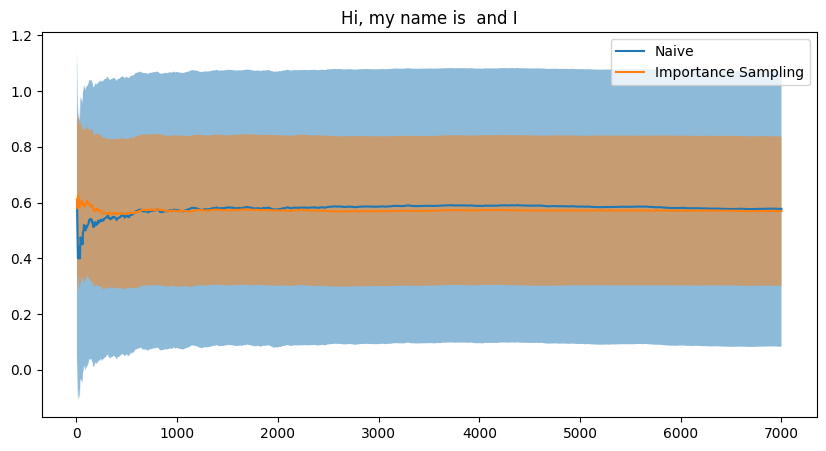

In [143]:
input_str, avoid_terms = "Hi, my name is", " and I"
naive_estimates, imp_estimates = [], []

for seed in SEEDS:
    naive_out = get_naive_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)
    naive_estimates.append(naive_out)
    
    imp_samp_out = get_imp_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)
    imp_estimates.append(imp_samp_out)
    
    
naive_probs, naive_samples = zip(*naive_estimates)
naive_probs = torch.cat(naive_probs)
naive_samples = torch.cat(naive_samples)

imp_probs, imp_samples = zip(*imp_estimates)
imp_probs = torch.cat(imp_probs)
imp_samples = torch.cat(imp_samples)

naive_mean, naive_std, naive_ids = compute_mean_std(naive_probs)
imp_mean, imp_std, imp_ids = compute_mean_std(imp_probs)

plt.figure(figsize=(10, 5))
ax = sns.lineplot(x=naive_ids, y=naive_mean, label="Naive")
ax.fill_between(naive_ids, *zip(*naive_std), alpha=0.5)

ax=sns.lineplot(x=imp_ids, y=imp_mean, label="Importance Sampling")
ax.fill_between(imp_ids, *zip(*imp_std), alpha=0.5)

plt.title(input_str + " " + avoid_terms)

Text(0.5, 1.0, 'Once upon a  time')

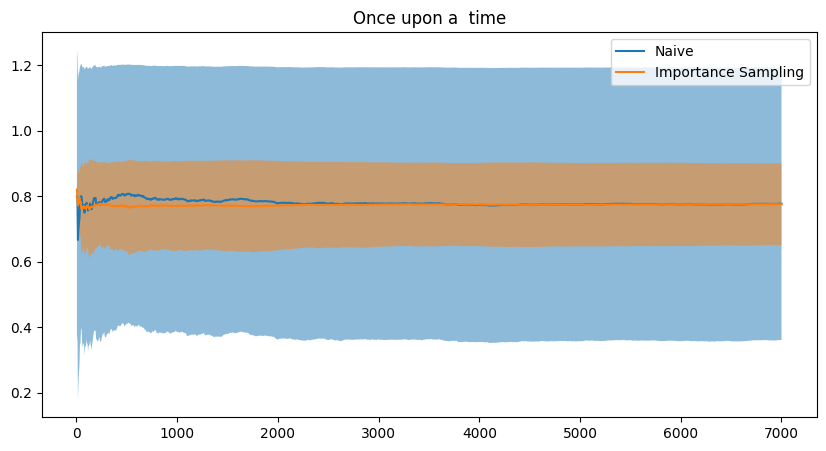

In [144]:
input_str, avoid_terms = "Once upon a", " time"
naive_estimates, imp_estimates = [], []

for seed in SEEDS:
    naive_out = get_naive_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)
    naive_estimates.append(naive_out)
    
    imp_samp_out = get_imp_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)
    imp_estimates.append(imp_samp_out)
    
    
naive_probs, naive_samples = zip(*naive_estimates)
naive_probs = torch.cat(naive_probs)
naive_samples = torch.cat(naive_samples)

imp_probs, imp_samples = zip(*imp_estimates)
imp_probs = torch.cat(imp_probs)
imp_samples = torch.cat(imp_samples)

naive_mean, naive_std, naive_ids = compute_mean_std(naive_probs)
imp_mean, imp_std, imp_ids = compute_mean_std(imp_probs)

plt.figure(figsize=(10, 5))
ax = sns.lineplot(x=naive_ids, y=naive_mean, label="Naive")
ax.fill_between(naive_ids, *zip(*naive_std), alpha=0.5)

ax=sns.lineplot(x=imp_ids, y=imp_mean, label="Importance Sampling")
ax.fill_between(imp_ids, *zip(*imp_std), alpha=0.5)

plt.title(input_str + " " + avoid_terms)

Text(0.5, 1.0, 'Where is  the he she next it ?')

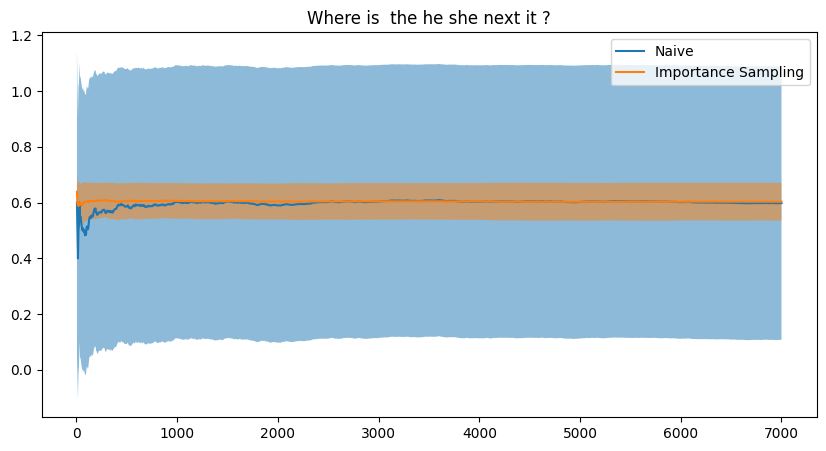

In [145]:
input_str, avoid_terms = "Where is", " the he she next it ?"
naive_estimates, imp_estimates = [], []

for seed in SEEDS:
    naive_out = get_naive_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)
    naive_estimates.append(naive_out)
    
    imp_samp_out = get_imp_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)
    imp_estimates.append(imp_samp_out)
    
    
naive_probs, naive_samples = zip(*naive_estimates)
naive_probs = torch.cat(naive_probs)
naive_samples = torch.cat(naive_samples)

imp_probs, imp_samples = zip(*imp_estimates)
imp_probs = torch.cat(imp_probs)
imp_samples = torch.cat(imp_samples)

naive_mean, naive_std, naive_ids = compute_mean_std(naive_probs)
imp_mean, imp_std, imp_ids = compute_mean_std(imp_probs)

plt.figure(figsize=(10, 5))
ax = sns.lineplot(x=naive_ids, y=naive_mean, label="Naive")
ax.fill_between(naive_ids, *zip(*naive_std), alpha=0.5)

ax=sns.lineplot(x=imp_ids, y=imp_mean, label="Importance Sampling")
ax.fill_between(imp_ids, *zip(*imp_std), alpha=0.5)

plt.title(input_str + " " + avoid_terms)